In [193]:
import pandas as pd
import numpy as np
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'DejaVu Sans'  # fonte padrão do matplotlib

In [194]:
import pyodbc
import pandas as pd

server_name = "JUNIOR"  # nome do servidor retornado
database_name = "Olist"

connection_string = f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server_name};DATABASE={database_name};Trusted_Connection=yes"

conn = pyodbc.connect(connection_string)

df_customers = pd.read_sql("SELECT * FROM customers", conn)
df_geolocation = pd.read_sql("SELECT * FROM geolocation", conn)
df_order_items = pd.read_sql("SELECT * FROM order_items", conn)
df_order_payments = pd.read_sql("SELECT * FROM order_payments", conn)
df_reviews = pd.read_sql("SELECT * FROM reviews", conn)
df_orders = pd.read_sql("SELECT * FROM orders", conn)
df_products = pd.read_sql("SELECT * FROM products", conn)
df_sellers = pd.read_sql("SELECT * FROM sellers", conn)
df_product_category_name_translation = pd.read_sql("SELECT * FROM product_category_name_translation", conn)


C:\Users\sidne\AppData\Local\Temp\ipykernel_17540\3159878578.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_customers = pd.read_sql("SELECT * FROM customers", conn)
C:\Users\sidne\AppData\Local\Temp\ipykernel_17540\3159878578.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_geolocation = pd.read_sql("SELECT * FROM geolocation", conn)
C:\Users\sidne\AppData\Local\Temp\ipykernel_17540\3159878578.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_order_items = pd.read_sql("SELECT * FROM order_items", conn)

#### 1. Visões Comerciais (Negócio):
##### Vendas:
* Vendas e faturamento
* Total vendido por período (sazonalidade).
* Produtos e categorias mais vendidos.
##### Clientes
* Segmentação de clientes por frequência de compra, ticket médio e localização.
* Análise de retenção: quantos clientes voltam a comprar?
* Cohort analysis (como grupos de clientes evoluem ao longo do tempo).
##### Pagamentos
* Preferência por método de pagamento (boleto, cartão, parcelado).
* Análise de inadimplência/estorno.

#### 1. Visões Comerciais (Negócio):
##### Vendas:
* Vendas e faturamento
* Total vendido por período (sazonalidade).
* Produtos e categorias mais vendidos.

In [195]:
# Cruzando a base de ordem do pedido com clientes
df_base = df_orders.merge(df_customers[['customer_id','customer_unique_id','customer_city','customer_state']], 
                                            on = 'customer_id', how = 'left')

In [196]:
# Cruzando com a base dos itens
df_base = df_base.merge(df_order_items[['order_id','product_id','price','freight_value']], on = 'order_id', how= 'left')

In [197]:
# Cruzando com a base dos produtos
df_base = df_base.merge(\
    df_products[['product_category_name','product_id','product_weight_g','product_length_cm','product_height_cm','product_width_cm']], on = 'product_id', how = 'left')

In [198]:
# Cruzando com a base dos reviews
df_base = df_base.merge(df_reviews[['order_id','review_score','review_comment_message']],\
                                            on = 'order_id',how = 'left')

In [199]:
# Cruzando com a base de ordem de pagamento
df_base = df_base.merge(df_order_payments[['order_id','payment_type','payment_installments']],\
                                            on = 'order_id', how = 'left')

In [200]:
# Verificando informações vazias
df_base.isna().sum()

order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                    0
order_delivered_carrier_date         0
order_delivered_customer_date        0
order_estimated_delivery_date        0
customer_unique_id                   0
customer_city                        0
customer_state                       0
product_id                         833
price                              833
freight_value                      833
product_category_name              833
product_weight_g                   833
product_length_cm                  833
product_height_cm                  833
product_width_cm                   833
review_score                       997
review_comment_message           68898
payment_type                         3
payment_installments                 3
dtype: int64

In [201]:
# ID do produto não pode ser vazio.
df_base = df_base.dropna(subset=['product_id'])

In [202]:
# Apos do Drop
df_base.isna().sum()

order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                    0
order_delivered_carrier_date         0
order_delivered_customer_date        0
order_estimated_delivery_date        0
customer_unique_id                   0
customer_city                        0
customer_state                       0
product_id                           0
price                                0
freight_value                        0
product_category_name                0
product_weight_g                     0
product_length_cm                    0
product_height_cm                    0
product_width_cm                     0
review_score                       978
review_comment_message           68628
payment_type                         3
payment_installments                 3
dtype: int64

In [203]:
# Analisando o type das colunas
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118310 entries, 0 to 119142
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   order_id                       118310 non-null  object
 1   customer_id                    118310 non-null  object
 2   order_status                   118310 non-null  object
 3   order_purchase_timestamp       118310 non-null  object
 4   order_approved_at              118310 non-null  object
 5   order_delivered_carrier_date   118310 non-null  object
 6   order_delivered_customer_date  118310 non-null  object
 7   order_estimated_delivery_date  118310 non-null  object
 8   customer_unique_id             118310 non-null  object
 9   customer_city                  118310 non-null  object
 10  customer_state                 118310 non-null  object
 11  product_id                     118310 non-null  object
 12  price                          118310 non-null  o

In [204]:
# To Data
df_base['order_purchase_timestamp'] = pd.to_datetime(df_base['order_purchase_timestamp']).dt.normalize()
df_base['order_approved_at'] = pd.to_datetime(df_base['order_approved_at']).dt.normalize()
df_base['order_delivered_carrier_date'] = pd.to_datetime(df_base['order_delivered_carrier_date']).dt.normalize()
df_base['order_delivered_customer_date'] = pd.to_datetime(df_base['order_delivered_customer_date']).dt.normalize()
df_base['order_estimated_delivery_date'] = pd.to_datetime(df_base['order_estimated_delivery_date']).dt.normalize()

# To String

df_base['order_status'] = df_base['order_status'].astype('string')
df_base['customer_city'] = df_base['customer_city'].astype('string')
df_base['customer_state'] = df_base['customer_state'].astype('string')
df_base['product_category_name'] = df_base['product_category_name'].astype('string')

# To Numeric
df_base['price'] = pd.to_numeric(df_base['price'])
df_base['freight_value'] = pd.to_numeric(df_base['freight_value'])
df_base['review_score'] = df_base['review_score'].fillna(0).astype(int)
df_base['product_weight_g'] = pd.to_numeric(df_base['product_weight_g'])
df_base['product_length_cm'] = pd.to_numeric(df_base['product_length_cm'])
df_base['product_height_cm'] = pd.to_numeric(df_base['product_height_cm'])
df_base['product_width_cm'] = pd.to_numeric(df_base['product_width_cm'])

In [205]:
# Apos a transformações do tipo da coluna, foi analisado que a quantidade de linhas estão diferentes
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118310 entries, 0 to 119142
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       118310 non-null  object        
 1   customer_id                    118310 non-null  object        
 2   order_status                   118310 non-null  string        
 3   order_purchase_timestamp       118310 non-null  datetime64[ns]
 4   order_approved_at              118295 non-null  datetime64[ns]
 5   order_delivered_carrier_date   117056 non-null  datetime64[ns]
 6   order_delivered_customer_date  115722 non-null  datetime64[ns]
 7   order_estimated_delivery_date  118310 non-null  datetime64[ns]
 8   customer_unique_id             118310 non-null  object        
 9   customer_city                  118310 non-null  string        
 10  customer_state                 118310 non-null  string        
 11  produ

In [206]:
#Pedidos sem essa data não podem ter rastreamento válido
df_base = df_base.dropna(subset=['order_delivered_carrier_date'])

In [207]:
# Sem peso, não é possível análise de custos logísticos
df_base = df_base.dropna(subset=['product_weight_g'])

In [208]:
# Pedidos não aprovados representam falha no processo de venda
df_base = df_base.dropna(subset=['order_approved_at'])

In [209]:
# Informação essencial para receita e conversão de vendas
df_base = df_base.dropna(subset=['payment_type'])

In [210]:
# Assegura que todos os registros tenham data válida para cálculo de prazos
df_base = df_base.dropna(subset=['order_delivered_customer_date'])

In [211]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115683 entries, 0 to 119142
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115683 non-null  object        
 1   customer_id                    115683 non-null  object        
 2   order_status                   115683 non-null  string        
 3   order_purchase_timestamp       115683 non-null  datetime64[ns]
 4   order_approved_at              115683 non-null  datetime64[ns]
 5   order_delivered_carrier_date   115683 non-null  datetime64[ns]
 6   order_delivered_customer_date  115683 non-null  datetime64[ns]
 7   order_estimated_delivery_date  115683 non-null  datetime64[ns]
 8   customer_unique_id             115683 non-null  object        
 9   customer_city                  115683 non-null  string        
 10  customer_state                 115683 non-null  string        
 11  produ

In [212]:
df_base['total_items'] = df_base['price'] + df_base['freight_value']

df_base['delivery_diff_days'] = pd.to_numeric(
    (df_base['order_delivered_customer_date'] - df_base['order_approved_at']).dt.days
)

df_base['estimated_diff_days'] = pd.to_numeric(
    (df_base['order_estimated_delivery_date'] - df_base['order_approved_at']).dt.days
)

df_base['dias_atraso'] = pd.to_numeric(
    df_base['delivery_diff_days'] - df_base['estimated_diff_days']
)

In [213]:
df_base.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,...,product_height_cm,product_width_cm,review_score,review_comment_message,payment_type,payment_installments,total_items,delivery_diff_days,estimated_diff_days,dias_atraso
0,6bf0953ea2856ef95e31030263eacc2e,a602a55269bd7ad0a6d3d7ef86ea249d,delivered,2017-02-11,2017-02-11,2017-02-15,2017-02-17,2017-03-10,bf90a7aa2fc913b4f227d1d2a9edf73d,sao paulo,...,11.0,18.0,4,None,credit_card,1,32.62,6,27,-21
1,338084a6f213912faa2ab6b87c6d388f,11e55f8da60d95653cfe027e0e90c51a,delivered,2018-04-09,2018-04-10,2018-04-10,2018-04-16,2018-04-25,9084ddf25334d2b3afaf25994ce72e98,diadema,...,11.0,20.0,4,"É um kit bom de qualidade, no entanto o pincel...",boleto,1,63.28,6,15,-9
2,621de62735eae3ffa4affa5e73d860db,422290a11dc46ec8ca6fb7e6bd45dd1b,delivered,2018-03-02,2018-03-02,2018-03-06,2018-04-03,2018-03-23,a53b34c2c302d82e6378f4b310fa41c6,ponta grossa,...,10.0,15.0,1,None,credit_card,1,156.73,32,21,11
3,36272970346cb4aadae6ef0defd79773,9df54e366988cfc2cebe295b76ca03e1,delivered,2018-03-16,2018-03-16,2018-03-19,2018-04-10,2018-04-05,8a2116bb6477d75ea533208c915be658,linhares,...,83.0,20.0,1,"Preciso da cadeira com urgência, pessoa com de...",boleto,1,599.30,25,20,5
4,7ab2b693aebb8e032fc16f9c75051fdc,10dd2ea9384e83d9cde6177042b4b55d,delivered,2018-02-20,2018-02-20,2018-03-01,2018-04-11,2018-03-23,c966cd5248ab87272ee8d8e9479880bc,fortaleza,...,6.0,23.0,2,não recebi o produto o prazo já acabou,credit_card,3,87.76,50,31,19


In [214]:
df_base[['order_purchase_timestamp','order_delivered_carrier_date','order_approved_at','order_delivered_customer_date','order_estimated_delivery_date','price','freight_value',\
         'product_weight_g','product_length_cm','product_height_cm','product_width_cm','delivery_diff_days','estimated_diff_days']].corr()

,order_purchase_timestamp,order_delivered_carrier_date,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,delivery_diff_days,estimated_diff_days
order_purchase_timestamp,1.000000,0.999715,0.999980,0.998088,0.998379,-0.000891,0.047113,-0.033084,-0.065432,-0.023803,-0.067242,-0.103578,-0.218966
order_delivered_carrier_date,0.999715,1.000000,0.999725,0.998392,0.998362,0.000650,0.049411,-0.029615,-0.063437,-0.020631,-0.066035,-0.094548,-0.214869
order_approved_at,0.999980,0.999725,1.000000,0.998102,0.998373,-0.000831,0.047285,-0.033014,-0.065388,-0.023740,-0.067253,-0.103686,-0.219428
order_delivered_customer_date,0.998088,0.998392,0.998102,1.000000,0.997778,0.002952,0.060577,-0.027961,-0.061558,-0.019666,-0.065090,-0.042234,-0.196769
order_estimated_delivery_date,0.998379,0.998362,0.998373,0.997778,1.000000,0.003173,0.063701,-0.028799,-0.062533,-0.019688,-0.065439,-0.082524,-0.163441
price,-0.000891,0.000650,-0.000831,0.002952,0.003173,1.000000,0.414418,0.338620,0.142730,0.222823,0.173039,0.061141,0.068670
freight_value,0.047113,0.049411,0.047285,0.060577,0.063701,0.414418,1.000000,0.610833,0.305026,0.391391,0.323637,0.211218,0.271833
product_weight_g,-0.033084,-0.029615,-0.033014,-0.027961,-0.028799,0.338620,0.610833,1.000000,0.460215,0.583236,0.507690,0.084014,0.078446
product_length_cm,-0.065432,-0.063437,-0.065388,-0.061558,-0.062533,0.142730,0.305026,0.460215,1.000000,0.191624,0.536101,0.066628,0.061371
product_height_cm,-0.023803,-0.020631,-0.023740,-0.019666,-0.019688,0.222823,0.391391,0.583236,0.191624,1.000000,0.278671,0.067531,0.073873


#### 1. Visões Comerciais (Negócio):

* Vendas e faturamento
* Total vendido por período (sazonalidade).

In [215]:
# Selecionando orders que foram entrega concretizada para os clientes.
Faturamento_Venda = df_base.loc[
    (df_base['order_status'] == 'delivered') & 
    (pd.to_datetime(df_base['order_delivered_customer_date'], errors='coerce').dt.year.isin([2016, 2017, 2018]))
]

In [216]:
# Fazendo um count para saber o comportamento dos clientes ao decorrer das safras
qtdeClientes = Faturamento_Venda.groupby(
    [Faturamento_Venda['order_delivered_customer_date'].dt.year.rename('ano'),
    Faturamento_Venda['order_delivered_customer_date'].dt.month.rename('mes')]
    )['customer_unique_id'].nunique().reset_index(name = 'QtdeVenda')

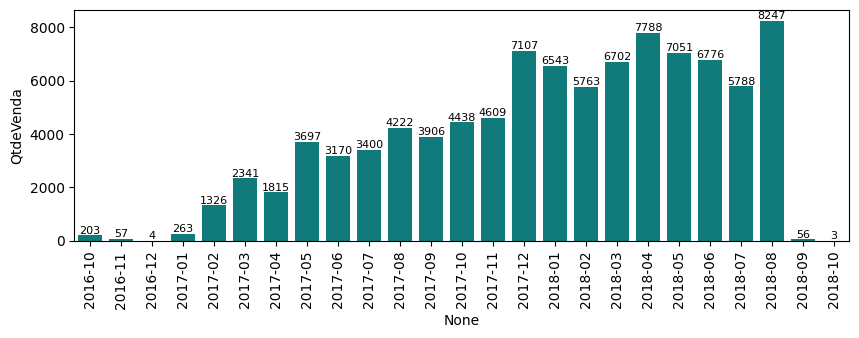

In [217]:
# Plotando a visão de quantidade clientes
plt.figure(figsize = (10,3))
ax = sns.barplot(x = qtdeClientes['ano'].astype(str) + '-' + qtdeClientes['mes'].astype(str).str.zfill(2),
                 y = qtdeClientes['QtdeVenda'],
                 color = 'darkcyan')
ax.bar_label(ax.containers[0], fontsize = 8, color = 'black')
plt.xticks(rotation = 90)
plt.show()

In [218]:
# Plotando o comportamento do faturamento
Faturamento = Faturamento_Venda.groupby(
    [Faturamento_Venda['order_delivered_customer_date'].dt.year.rename('ano'),
     Faturamento_Venda['order_delivered_customer_date'].dt.month.rename('mes')]
)['total_items'].sum().reset_index(name='total_venda')

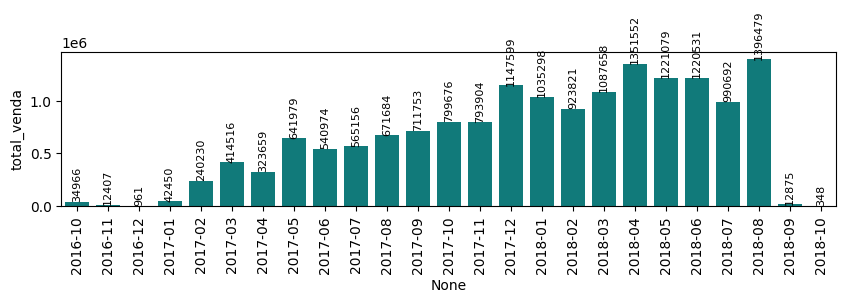

In [219]:
# Plotando visão de Faturamento
plt.figure(figsize = (10,2))
ax = sns.barplot(
            x = Faturamento['ano'].astype(str) + '-' + Faturamento['mes'].astype(str).str.zfill(2),
            y = Faturamento['total_venda'],
            color = 'darkcyan'
)
ax.bar_label(ax.containers[0], fontsize = 8, color = 'black', fmt = '%.0f',rotation = 90)
plt.xticks(rotation = 90)
plt.show()

#### 1. Visões Comerciais (Negócio):
##### Vendas:
* Produtos e categorias mais vendidos.

In [220]:
# Quantidade de clientes que fizeram a compra dos cinco produtos mais vendidos
product_category_Qtde = Faturamento_Venda.groupby(
    Faturamento_Venda['product_category_name']
)['customer_unique_id'].nunique().sort_values(ascending = False).head().reset_index(name = 'QtdeVenda')

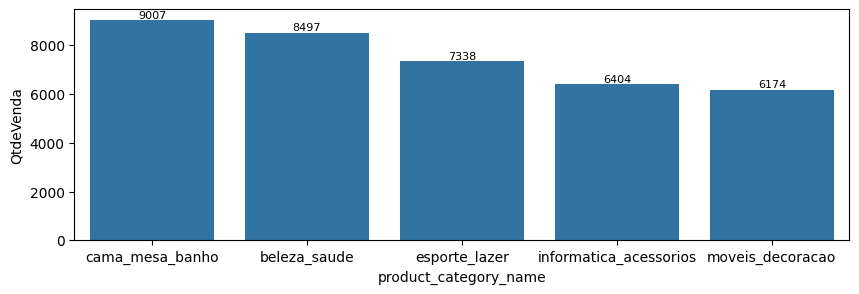

In [221]:
# Produtos mais comprados
plt.figure(figsize=(10,3))
ax = sns.barplot(
    x = product_category_Qtde['product_category_name'],
    y = product_category_Qtde['QtdeVenda']
)
ax.bar_label(ax.containers[0], fontsize = 8, color = 'black', fmt = '%.0f')
plt.show()

In [222]:
product_category_Valor = Faturamento_Venda.groupby(
    Faturamento_Venda['product_category_name']
)['total_items'].sum().sort_values(ascending = False).head().reset_index(name = 'total_venda')

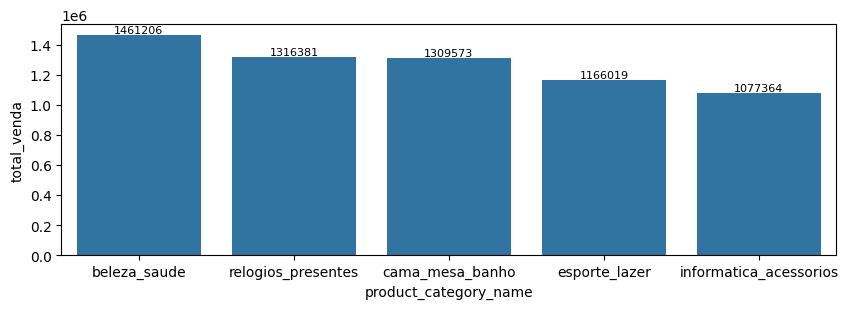

In [223]:
plt.figure(figsize=(10,3))
ax = sns.barplot(
    x = product_category_Valor['product_category_name'],
    y = product_category_Valor['total_venda']
) 
ax.bar_label(ax.containers[0], fontsize = 8, color = 'black', fmt = '%.0f')
plt.show()

##### Clientes
* Segmentação de clientes por frequência de compra, ticket médio e localização.
* Análise de retenção: quantos clientes voltam a comprar?
* Cohort analysis (como grupos de clientes evoluem ao longo do tempo).

In [224]:
# Segmentação de clientes
SegmentacaoCliente = Faturamento_Venda.groupby('customer_unique_id').agg(
    {
        "order_id": "nunique",
        "total_items": "sum",
        "order_purchase_timestamp": "min",
        "customer_city":"last",
        "customer_state":"last"
    }
).reset_index()

In [225]:
SegmentacaoCliente['ticket_medio'] = round(SegmentacaoCliente['total_items']/SegmentacaoCliente['order_id'],2)

In [226]:
SegmentacaoCliente.head()

,customer_unique_id,order_id,total_items,order_purchase_timestamp,customer_city,customer_state,ticket_medio
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,2018-05-10,cajamar,SP,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,2018-05-07,osasco,SP,27.19
2,0000f46a3911fa3c0805444483337064,1,86.22,2017-03-10,sao jose,SC,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,2017-10-12,belem,PA,43.62
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,2017-11-14,sorocaba,SP,196.89


In [227]:
def segmenta_cliente(row):
    if row['order_id'] == 1:
        return 'Cliente Unico'
    elif row['order_id'] <= 3:
        return "Cliente Recorrente"
    else:
        return "Cliente Fiel"

In [228]:
SegmentacaoCliente['segmento'] = SegmentacaoCliente.apply(segmenta_cliente, axis=1)

* Análise de retenção: quantos clientes voltam a comprar?

In [229]:
SegmentacaoCliente['segmento'].value_counts()

segmento
Cliente Unico         90525
Cliente Recorrente     2750
Cliente Fiel             47
Name: count, dtype: int64

In [230]:
SegmentacaoCliente['cohort_month'] = SegmentacaoCliente['order_purchase_timestamp'].dt.to_period('M')

* Cohort analysis (como grupos de clientes evoluem ao longo do tempo).

In [231]:
SegmentacaoCliente['months_active'] = Faturamento_Venda.groupby('customer_unique_id')['order_purchase_timestamp']\
    .agg(lambda x: (x.max().to_period('M') - x.min().to_period('M')).n+1)\
    .reset_index(drop = True)

##### Pagamentos
* Preferência por método de pagamento (boleto, cartão, parcelado).
* Análise de inadimplência/estorno.

In [232]:
# Preferencia em modo de pagamento
Faturamento_Venda['payment_type'].value_counts()

payment_type
credit_card    85350
boleto         22486
voucher         6179
debit_card      1661
Name: count, dtype: int64

In [233]:
# Preferencia de quantas vezes o cliente deseja fazer o pagamento
Faturamento_Venda[Faturamento_Venda['payment_type'] == 'credit_card'].groupby('payment_installments')['customer_unique_id'].\
count().reset_index(name='qtde_clientes').sort_values('qtde_clientes', ascending=False).head(5)

,payment_installments,qtde_clientes
1,1,27325
11,2,13478
17,3,11567
18,4,7848
2,10,6760


#### 2. Visões Operacionais (Logística e Atendimento)

##### Logística
    * Tempo médio de entrega real vs estimado.
    * Regiões com maior atraso.
    * Custos implícitos em entregas longas.
##### Atendimento
    * Análise de reviews (avaliação média por categoria, estado, vendedor).
    * Identificação de fatores que geram reviews ruins (atraso, produto defeituoso, frete alto).

In [234]:
def definir_regiao (estado):
    if estado in ['AC','AM','AP','PA','RO','RR','TO']:
        return 'NORTE'
    elif estado in ['MA','BA','CE','MA','PB','PI','PE','RN','SE']:
        return 'NORDESTE'
    elif estado in ['MT','DF','MS','GO']:
        return 'CENTRO-OESTE'
    elif estado in ['MG','ES','RJ','SP']:
        return 'SUDESTE'
    elif estado in ['PR','SC','RS']:
        return 'SUL'

In [235]:
Faturamento_Venda['Regiao'] = Faturamento_Venda['customer_state'].apply(definir_regiao)

C:\Users\sidne\AppData\Local\Temp\ipykernel_17540\704798324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Faturamento_Venda['Regiao'] = Faturamento_Venda['customer_state'].apply(definir_regiao)


In [236]:
Faturamento_Venda['dias_atraso'] = np.select(
    [
        Faturamento_Venda['dias_atraso'] < -3,
        (Faturamento_Venda['dias_atraso'] >= -3) & (Faturamento_Venda['dias_atraso'] < 0),
        Faturamento_Venda['dias_atraso'] == 0,
        (Faturamento_Venda['dias_atraso'] > 0) & (Faturamento_Venda['dias_atraso'] <= 3),
         Faturamento_Venda['dias_atraso'] > 3
    ],
    [
        'Adiantada Forte',
        'Adiantada Leve',
        'No Prazo',
        'Atraso Leve',
        'Atraso Forte'
    ]
)

C:\Users\sidne\AppData\Local\Temp\ipykernel_17540\181219686.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Faturamento_Venda['dias_atraso'] = np.select(


In [237]:
Faturamento_Venda.groupby('Regiao').agg(
    {
    "total_items":"sum",
    "freight_value":"mean",
    "delivery_diff_days":"mean",
    "estimated_diff_days":"mean"
    }
).sort_values(by = 'freight_value', ascending = False)

,total_items,freight_value,delivery_diff_days,estimated_diff_days
Regiao,,,,
NORTE,420247.41,37.060271,21.851306,37.625178
NORDESTE,1827381.90,31.969293,19.043648,30.713993
CENTRO-OESTE,1041562.93,22.970105,14.298966,26.762925
SUL,2334888.95,21.217270,13.361286,26.631102
SUDESTE,10460443.01,17.389880,10.152458,21.878637


In [238]:
Faturamento_Venda.groupby('dias_atraso')['customer_unique_id'].count()

dias_atraso
Adiantada Forte    101085
Adiantada Leve       5528
Atraso Forte         5386
Atraso Leve          2168
No Prazo             1509
Name: customer_unique_id, dtype: int64

In [239]:
df_atraso = Faturamento_Venda[Faturamento_Venda['dias_atraso'] == 'Atraso Forte']\
    .sort_values(by = 'dias_atraso',ascending= False)

In [240]:
# Cruzar com a base de reviews para identificar os fatores que levam ao atraso dos produtos


In [241]:
def definir_classificacao(x):
    if x in [5.0,4.0]:
        return 'Satisfied'
    elif x in [3.0]:
        return 'Neutral'
    elif x in [2.0,1.0]:
        return 'Unsatisfied'

In [242]:
Faturamento_Venda['review_category'] = Faturamento_Venda['review_score'].apply(definir_classificacao)

C:\Users\sidne\AppData\Local\Temp\ipykernel_17540\3097453891.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Faturamento_Venda['review_category'] = Faturamento_Venda['review_score'].apply(definir_classificacao)


#### Satisfação por região

* A maior concentração de clientes satisfeitos está no Sudeste e Sul, que também são as regiões com maior volume de entregas.

* O Nordeste tem uma quantidade significativa de clientes insatisfeitos, proporcionalmente maior do que outras regiões, mesmo com entregas majoritariamente adiantadas.

* O Norte apresenta menor volume total, mas uma proporção considerável de clientes neutros e insatisfeitos.

In [243]:
    Faturamento_Venda\
    .groupby(['Regiao', 'dias_atraso'])\
    .agg({'customer_unique_id':'nunique'})\
    .reset_index()\
    .pivot(index='Regiao', columns='dias_atraso', values='customer_unique_id')\
    .fillna(0)

dias_atraso,Adiantada Forte,Adiantada Leve,Atraso Forte,Atraso Leve,No Prazo
Regiao,,,,,
CENTRO-OESTE,4770,260,252,113,80
NORDESTE,6864,411,828,235,136
NORTE,1526,52,124,30,22
SUDESTE,56024,3415,2805,1225,880
SUL,11918,558,561,250,159


#### Distribuição do status de entrega por região

* A maioria das entregas está concentrada no Sudeste, seguida pelo Sul e Nordeste.

* A maior parte das entregas é adiantada forte ou adiantada leve, indicando que, em geral, a logística está funcionando bem para antecipar prazos.

* Regiões como Norte e Centro-Oeste apresentam menores volumes, mas proporcionalmente ainda têm mais entregas adiantadas do que atrasadas.

In [244]:
    Faturamento_Venda\
    .groupby(['dias_atraso', 'payment_type'])\
    .agg({'customer_unique_id':'nunique'})\
    .reset_index()\
    .pivot(index='payment_type', columns='dias_atraso', values='customer_unique_id')\
    .fillna(0)

dias_atraso,Adiantada Forte,Adiantada Leve,Atraso Forte,Atraso Leve,No Prazo
payment_type,,,,,
boleto,16007,1083,994,407,298
credit_card,63045,3475,3525,1417,934
debit_card,1249,104,55,24,39
voucher,3194,152,167,53,38


#### Satisfação por região

* A maior concentração de clientes satisfeitos está no Sudeste e Sul, que também são as regiões com maior volume de entregas.

* O Nordeste tem uma quantidade significativa de clientes insatisfeitos, proporcionalmente maior do que outras regiões, mesmo com entregas majoritariamente adiantadas.

* O Norte apresenta menor volume total, mas uma proporção considerável de clientes neutros e insatisfeitos.

In [245]:
    Faturamento_Venda\
    .groupby(['Regiao', 'payment_type'])\
    .agg({'customer_unique_id':'nunique'})\
    .reset_index()\
    .pivot(index='payment_type', columns='Regiao', values='customer_unique_id')\
    .fillna(0)

Regiao,CENTRO-OESTE,NORDESTE,NORTE,SUDESTE,SUL
payment_type,,,,,
boleto,1189,1550,400,12338,3161
credit_card,4145,6616,1294,49752,9899
debit_card,54,128,26,1069,189
voucher,190,385,67,2465,476


#### 3. Visões Preditivas (Modelagem de Dados)

* Previsão de demanda:

        Modelos de séries temporais para prever vendas futuras por região.

In [246]:
print(list(Faturamento_Venda))

['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'customer_unique_id', 'customer_city', 'customer_state', 'product_id', 'price', 'freight_value', 'product_category_name', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'review_score', 'review_comment_message', 'payment_type', 'payment_installments', 'total_items', 'delivery_diff_days', 'estimated_diff_days', 'dias_atraso', 'Regiao', 'review_category']


In [247]:
Faturamento_Venda['week_first_sales'] = Faturamento_Venda['order_purchase_timestamp'].dt.to_period('W').apply(lambda r:r.start_time)

C:\Users\sidne\AppData\Local\Temp\ipykernel_17540\1831093637.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Faturamento_Venda['week_first_sales'] = Faturamento_Venda['order_purchase_timestamp'].dt.to_period('W').apply(lambda r:r.start_time)


In [248]:
Faturamento_Venda['month_sales'] = Faturamento_Venda['order_purchase_timestamp'].dt.to_period('M').astype('str')

C:\Users\sidne\AppData\Local\Temp\ipykernel_17540\1380299439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Faturamento_Venda['month_sales'] = Faturamento_Venda['order_purchase_timestamp'].dt.to_period('M').astype('str')


#### Previsão de demanda:

    - Modelos de séries temporais para prever vendas futuras por região

In [249]:
df_series = Faturamento_Venda.groupby(['order_purchase_timestamp','Regiao']).agg(
    {
        'total_items':'sum'
    }
).reset_index().rename(columns={'order_purchase_timestamp':'ds','total_items':'y'}).sort_values('ds')

In [250]:
# Vamos usar o MODELO SARIMA.
from statsmodels.tsa.stattools import adfuller

resultado = adfuller(df_series['y'])
print('ADF Statistic:', resultado[0])
print('p-value:', resultado[1])


ADF Statistic: -4.245174137765641
p-value: 0.0005520149348569789


In [251]:
from pmdarima import auto_arima
modelo = auto_arima(
    df_series['y'],
    seasonal=True,
    m=12,
    start_p=0, start_q=0,
    max_p=2, max_q=2,
    start_P=0, start_Q=0,
    max_P=1, max_Q=1,
    d=0,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,  # ⬅️ O stepwise já reduz bastante as combinações
    n_fits=30,      # ⬅️ Limitar número de modelos testados
    n_jobs=1
)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=62627.245, Time=0.19 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=61919.619, Time=2.21 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=11.45 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=62625.271, Time=0.24 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=62598.414, Time=0.32 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=60971.394, Time=13.69 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=11.73 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=11.74 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=11.34 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=16.07 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=13.00 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=12.17 sec
 ARIMA(1,0,0)(1,1,1)[12]             : AIC=inf, Time=2.80 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12] intercept
Total fit time: 106.969 seconds


In [252]:
modelo

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(1, 1, 1, 12),
      suppress_warnings=True)

In [253]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

previsao_por_Regiao = {}

for regiao in df_series['Regiao'].unique():
    print(f'Carregando Regiao: {regiao}' )

    dados_regiao = df_series[df_series['Regiao'] == regiao]

    # Verificar se a quantidade de dados é maior que 10
    if len(dados_regiao) > 10:
        modelo = SARIMAX(
            dados_regiao['y'],
            order=(1,0,0),
            seasonal_order=(1,1,1,12)
        )
        
        resultado = modelo.fit()
        previsao = resultado.forecast(steps = 1)
        previsao_por_Regiao[regiao] = previsao.iloc[0]
        
        print(f"Previsão para {regiao}: R$ {previsao.iloc[0]:.2f}")
    else:
        print(f"⚠️ Dados insuficientes para {regiao}")

        # Mostra o resultado final
        print("\n" + "="*50)
        print("PREVISÕES FINAIS POR REGIÃO:")
        for regiao, valor in previsoes_por_regiao.items():
            print(f"{regiao}: R$ {valor:.2f}")

Carregando Regiao: CENTRO-OESTE


C:\Users\sidne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\sidne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\sidne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sidne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.p

Previsão para CENTRO-OESTE: R$ 1784.27
Carregando Regiao: SUDESTE


C:\Users\sidne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sidne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sidne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\sidne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

Previsão para SUDESTE: R$ 13629.95
Carregando Regiao: SUL


C:\Users\sidne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sidne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sidne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\sidne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

Previsão para SUL: R$ 4375.93
Carregando Regiao: NORDESTE


C:\Users\sidne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sidne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sidne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\sidne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

Previsão para NORDESTE: R$ 3105.26
Carregando Regiao: NORTE
Previsão para NORTE: R$ 1010.15


C:\Users\sidne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sidne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [254]:
previsao_por_Regiao

{'CENTRO-OESTE': 1784.2724945952493,
 'SUDESTE': 13629.947787498551,
 'SUL': 4375.925329750916,
 'NORDESTE': 3105.259495718348,
 'NORTE': 1010.1478950178576}

In [255]:
for regiao, previsao in previsao_por_Regiao.items():
    historico = df_series[df_series['Regiao'] == regiao]['y']
    media_historica = historico.mean()
    percentual = ((previsao - media_historica) / media_historica * 100)
    
    print(f"{regiao}: Previsão R$ {previsao:.2f} vs Média R$ {media_historica:.2f} | Variação: {percentual:.1f}%")

CENTRO-OESTE: Previsão R$ 1784.27 vs Média R$ 1765.36 | Variação: 1.1%
SUDESTE: Previsão R$ 13629.95 vs Média R$ 17148.27 | Variação: -20.5%
SUL: Previsão R$ 4375.93 vs Média R$ 3833.97 | Variação: 14.1%
NORDESTE: Previsão R$ 3105.26 vs Média R$ 3060.94 | Variação: 1.4%
NORTE: Previsão R$ 1010.15 vs Média R$ 776.80 | Variação: 30.0%
